# Una questione di qualità: l’uso dei connettivi nelle produzioni scritte di studenti italofoni

This notebook contains the analysis for the presentation "Una questione di qualità: l’uso dei connettivi nelle produzioni scritte di studenti italofoni", discussed at Universität Basel, 13-14 November.

The research questions are: 

1. Does the use of connectives (in terms of number of tokens, number of types and sophistication) change as a function of training in writing?
2. Does number of connectives, variety (RTTR/entropy/normalized entropy) or sophistication of connectives used correlate with holistic judgements of textual coherence?
3. Does accuracy in using connectives correlates with holistic judgements of textual coherence? If so, which are the most 'problematic' connectives? Which are the most 'problematic' discourse relations?

In this notebook we will report the procedures followed to answer RQ1.

In [2]:
# Check locale settings

Sys.getlocale()
l10n_info()

[1] "C"

$MBCS
[1] FALSE

$`UTF-8`
[1] FALSE

$`Latin-1`
[1] FALSE

$codeset
[1] "US-ASCII"

In [3]:
# If your locale is 'C' and codeset is different than 'UTF-8'
# you maybe want to set your locale to be able to handle special characters.

Sys.setlocale("LC_CTYPE", "en_US.UTF-8")

[1] "en_US.UTF-8"

In [4]:
# load libraries

library(tidyverse)
library(readxl)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


The data used for this analysis come from a [previous analysis](https://gitlab.inf.unibz.it/commul/lca/lcr22_itaca) presented at LCR2022 and published in Bienati & Frey (forth.) on the influence of language background and school grade on the use of (causal) connectives. 

This analysis focused just on student data with different language backgrounds. Now we extend it to include adult writing, keeping the language background stable (focusing just on L1 data). Thus our focus will be on the development in connective usage across different levels of training in writing, from middle school to adulthood.

In [5]:
# load frequency tables

data <- read.table("source/frequency_tables/combined_df.txt",
                   header = TRUE, sep = "\t", quote = "",
                   fileEncoding =  "utf-8", stringsAsFactors = TRUE)
nrow(data)

data_norm <- read.table("source/frequency_tables/combined_df_norm100words.txt",
                        header = TRUE, sep = "\t", quote = "",
                        fileEncoding =  "utf-8", stringsAsFactors = TRUE)
nrow(data_norm)

data_moving <- read.table("source/frequency_tables/combined_df_moving.txt",
                          header = TRUE, sep = "\t", quote = "",
                          fileEncoding =  "utf-8", stringsAsFactors = TRUE)
length(unique(data_moving$doc_id))

# Notes:
# in the moving averaged dataset there is one file missing.
# this depends on a previous step in the pipeline
# that we are not going to fix for this analysis.

[1] 300

[1] 300

[1] 299

In [6]:
# vector that contains causal connectives, useful for the analysis ?

causal_connectives <- c("a.causa.d.", "al.che", "allora",
  "come.conseguenza", "con.ciò",
  "con.questo", "cosicché", "così.che", "così",
  "da.ciò", "dal.momento.che", "dato.che",
  "di.conseguenza", "di.modo.che", "dimodoché", "dunque",
  #e, ed, da.allora, del.resto,
  # # excluded since causal sense is just a tiny proportion of all uses
  # and is not mentioned in dictionaries
  "ebbene", "giacché", "in.base.a.", "in.consequenza.di.ciò", "in.modo.che",
  "in.modo.da", "in.quanto", "in.seguito.a.", "in.seguito.a.ciò",
  "per", "perché", "perciò", "pertanto", "poiché", "per.cui",
  "per.il.fatto.che", "per.la.qual.cosa", "per.questa.ragione",
  "per.tutti.questi.motivi", "per.questo", "per.quest..motiv.",
  "per.via.d.", "quindi", "siccome", "visto.che"
)

Take care of renaming columns an merging variants

In [7]:
conn_cols <- data %>%
  select(where(is.numeric)) %>%   # Select numeric columns
  names() %>%
  discard(~ str_detect(., "num_") | str_detect(., "var_"))

replacements <- c(
  "d\\.$" = "d",     # Replace "d." at the end with "d"
  "a\\.$" = "a",     # Replace "a." at the end with "a"
  "t\\." = "to",     # Replace "t." with "to"
  "v\\." = "vo",      # Replace "v." with "vo"
  "\\.\\." = "."    # Replace ".." with "."
)

new_conn_cols <- str_replace_all(conn_cols, replacements)
names(data)[names(data) %in% conn_cols] <- new_conn_cols
names(data_norm)[names(data_norm) %in% conn_cols] <- new_conn_cols
names(data_moving)[names(data_moving) %in% conn_cols] <- new_conn_cols

In [8]:
# prepare dictionary for merging variants

variants_dict <- list(
  "cionondimeno" = "ciò.nondimeno",
  "ciononostante" = c("ciò.nonostante", "nonostante.ciò"),
  "con.ciò" = "con.questo",
  "così.che" = "cosicché",
  "infatti" = "difatti",
  "di.modo.che" = c("dimodoché", "in.modo.che", "in.modo.da"),
  "dopo.di.che" = "dopodiché",
  "e" = "ed",
  "ad.ogni.modo" = "in.ogni.modo",
  "a.dire.la.verità" = c("in.verità", "per.la.verità"),
  "innanzitutto" = "innanzi.tutto",
  "invece.d" = "invece.che",
  "non.prima.d" = c("non.prima.della", "non.prima.di"),
  "per.meglio.dire" = "o.meglio",
  "o" = "od",
  "oltre.a.ciò" = "oltre.a.questo",
  "peraltro" = "per.altro",
  "ad.esempio" = "per.esempio",
  "persino" = "perfino",
  "però" = "pero",
  "prima.che" = "prima.d",
  "seppure" = "seppur",
  "a.meno.che" = "a.meno.d"
)

In [9]:
merge_variants <- function(data, dict) {
  for (main_form in names(dict)) {
    variants <- dict[[main_form]]
    # Check if main form exists in the data
    if (main_form %in% names(data)) {
      # Sum the values of the variants into the main form column
      data <- data %>%
        mutate(!!main_form := rowSums(select(., all_of(c(main_form, variants))),
                                     na.rm = TRUE)) %>%
        select(-all_of(variants)) # Remove variant columns after summing
    } else {
      present_variants <- variants[variants %in% names(data)]
      if (length(present_variants) > 1) {
        # Merge the variant columns first
        merged_column <- rowSums(data[, all_of(present_variants)], na.rm = TRUE)
        # Then rename the merged column to the main form
        data <- data %>%
          mutate(!!main_form := merged_column) %>%
          select(-all_of(present_variants))
      } else if (length(present_variants) == 1) {
        # For 1-to-1 mapping, just rename the variant column
        data <- data %>%
          rename(!!main_form := !!present_variants[1])
      }
    }
  }
  return(data)
}

data <- merge_variants(data, variants_dict)
data_norm <- merge_variants(data_norm, variants_dict)
data_moving <- merge_variants(data_moving, variants_dict)

Warning message:
“Using `all_of()` outside of a selecting function was deprecated in tidyselect
1.2.0.
ℹ See details at
  <https://tidyselect.r-lib.org/reference/faq-selection-context.html>”


Add info on sophistication for all connectives

In [10]:
conn_cols <- data %>%
  select(where(is.numeric)) %>%   # Select numeric columns
  names() %>%
  discard(~ str_detect(., "num_") | str_detect(., "var_"))

dict <- read_excel("source/pulizia_connettivi.xlsx", sheet = "foglio_di_lavoro")
dict <- dict %>%
  select(lemma = lemma_di_citazione,
    coris_freq = frequenza_di_occorrenza,
    demauro_use = marca_uso
  ) %>%
  distinct(lemma, .keep_all = TRUE)

lemma <- dict %>%
  pull(lemma)

conn_missing <- setdiff(conn_cols, lemma)
writeLines(conn_missing, "output/conn_missing.txt")

In [11]:
# # get a handcrafted frequency list indicating how many times
# # the connectives of interest were used in the reference corpus CORIS

# coris_freq <- read_excel("source/pulizia_connettivi.xlsx",
#                          sheet = "foglio_di_lavoro")
# coris_freq_used <- coris_freq[coris_freq$lemma_di_citazione %in% colnames(data),]

# # Sophistication & Range
# # ***********************
# # go through observations and create for each text a list with
# # the coris frequency for each connective used in the text,
# # using the lookup table
# # then get mean (sophistication) and sd (range) of frequencies

# data$range <- NA
# for (y in seq_len(nrow(data))){
#   freqs <- list()
#   for (i in seq_len(nrow(coris_freq_used))){
#     con <- coris_freq_used$lemma_di_citazione[i]
#     freqs[[con]] =  rep(coris_freq_used$frequenza_di_occorrenza[i], data[y, con])
#   }
#   freq_vec <- unlist(freqs)
#   data[y,'range'] <- sd(freq_vec)
#   data[y,'sophistication'] <- mean(freq_vec)
# }

In [12]:
data_long <- data %>%
  pivot_longer(cols = all_of(conn_cols),
               names_to = "lemma", values_to = "count") %>%
  left_join(dict, by = "lemma") %>%
  mutate(freq_rep = map2(count, coris_freq, ~ rep(.y, .x)))

[1] 4

[1] 16028

[1] 622401

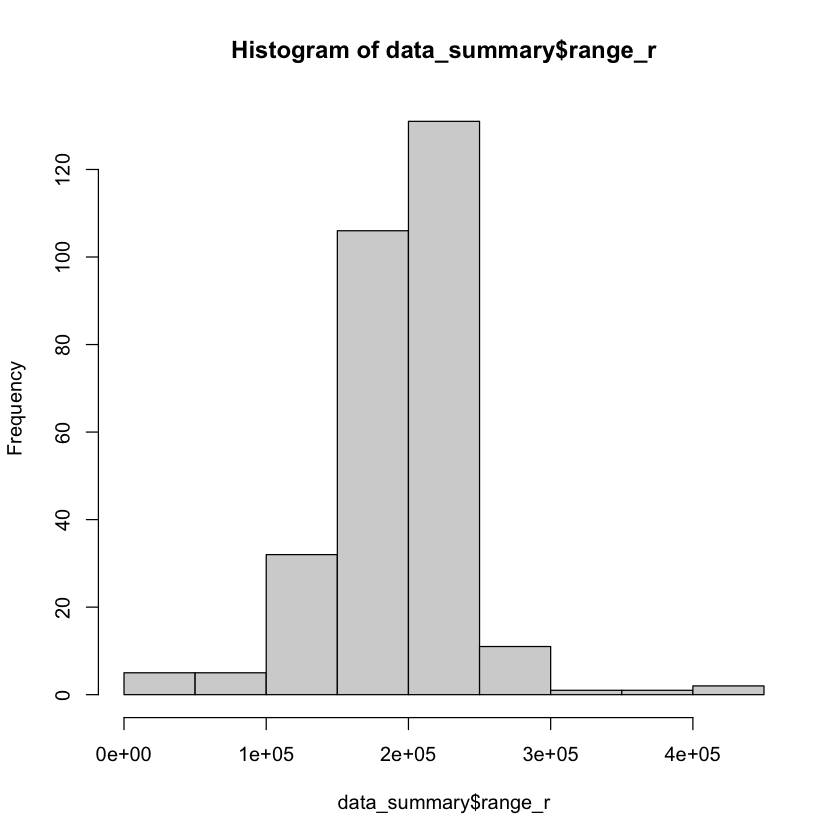

In [13]:
data_summary <- data_long %>%
  group_by(doc_id) %>%
  filter(!lemma %in% c("e", "o")) %>%
  summarize(
    sophistication = mean(unlist(freq_rep), na.rm = TRUE),
    range_r = sd(unlist(freq_rep), na.rm = TRUE)
  ) %>%
  mutate(
    sophistication_log = log10(sophistication),
    range_log = if_else(is.infinite(log10(range_r)), 0, log10(range_r))
  )

hist(data_summary$range_r)
sum(is.na(data_summary$sophistication))

min(data_summary$sophistication, na.rm = TRUE)
max(data_summary$sophistication, na.rm = TRUE)

In [14]:
data <- data %>%
  left_join(data_summary, by = "doc_id")

Summarize moving average data and merge back to data

In [15]:
data_moving$num_connectives_moving <- rowSums(data_moving[, colnames(data_moving) %in% conn_cols]) # nolint: line_length_linter.
data_moving$num_types_connectives_moving <- rowSums(data_moving[, colnames(data_moving) %in% conn_cols] > 0) # nolint: line_length_linter.

In [16]:
summarized_data_moving <- data_moving %>%
  group_by(doc_id) %>%
  summarize(num_connectives_moving = mean(num_connectives_moving),
    types_connectives_moving = mean(num_types_connectives_moving),
  )

In [17]:
# get important variables from df data
selected_var <- c("doc_id", "group",
                  "num_tokens", "num_connectives", "var_connectives",
                  "sophistication", "range_r")

summarized_data <- data %>%
  select(all_of(selected_var)) %>%
  mutate(rttr = var_connectives / sqrt(num_connectives)) %>%

  left_join(summarized_data_moving, by = "doc_id")

summarized_data_l1 <- summarized_data %>%
  filter(group %in% c("L1_lower", "L1_upper", "coris", "blogs")) %>%
  mutate(group = factor(group,
                        levels = c("L1_lower", "L1_upper", "coris", "blogs"),
                        labels = c("medie_arg",
                                   "superiori_arg",
                                   "adulti_esp",
                                   "adulti_arg")))

head(summarized_data_l1)

,doc_id,group,num_tokens,num_connectives,var_connectives,sophistication,range_r,rttr,num_connectives_moving,types_connectives_moving
,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AC20PA_CON02M,superiori_arg,635,50,17,223277.3,204345.9,2.404163,3.899317,2.988055
2,AC20PA_DEF26G,superiori_arg,753,72,16,321219.6,193348.9,1.885618,4.609375,3.350852
3,AC20PA_TEZ11S,superiori_arg,678,38,13,308589.4,241999.2,2.108878,2.786963,2.281399
4,AL07BN_BOZ11G,superiori_arg,685,53,23,240667.9,220605.4,3.159293,3.919811,3.666667
5,AV05GH_SAR05N,superiori_arg,725,48,25,222911.3,230512.3,3.608439,3.389053,3.113905
6,BA13PA_ABC12D,superiori_arg,722,58,20,284455.9,231831.6,2.626129,4.151560,3.114413


### Text length differences

Since text length differences are noticeable, we will refer always to the moving average data, as it minimizes text length effects.

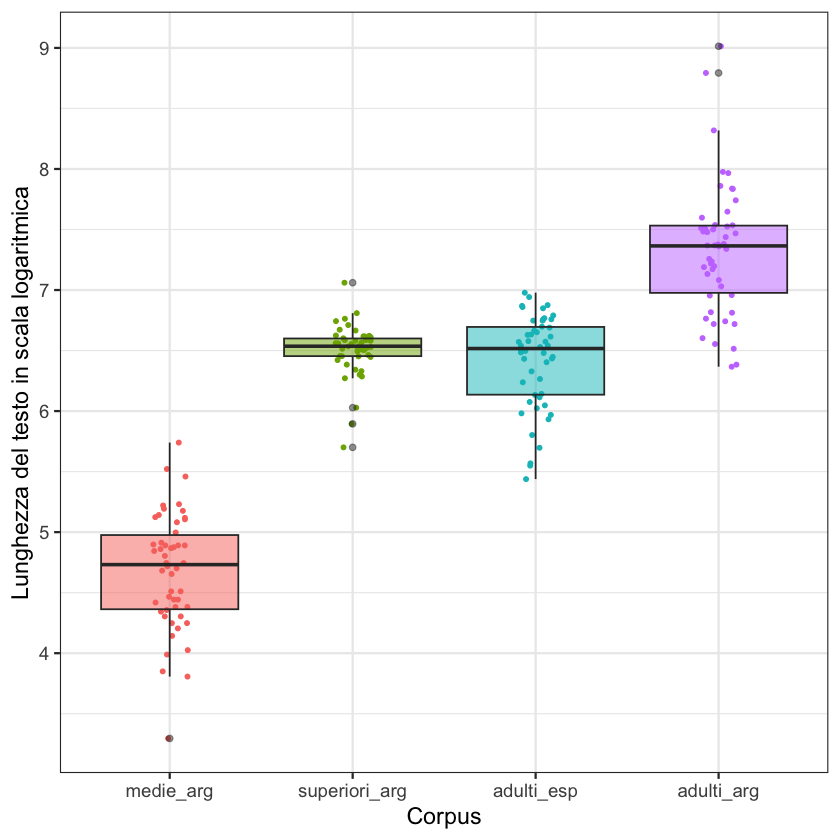

In [18]:
plt_lengths <- summarized_data_l1 %>%
  ggplot(aes(x = group, y = log(num_tokens))) +
  geom_jitter(aes(col = group), width = 0.1, size = 1) +
  geom_boxplot(aes(fill = group), alpha = 0.5) +
  xlab("Corpus") +
  ylab("Lunghezza del testo in scala logaritmica") +
  theme_bw(base_size = 14) +
  theme(legend.position = "none")

plt_lengths
ggsave("figures/text_length_diff.png", plt_lengths,
       device = "png", create.dir = TRUE,
       width = 6, height = 6, dpi = 600, bg = "transparent")

### Models & viz

In [34]:
# Convert to long format for the variables of interest

metrics <- c("num_connectives_moving", "rttr", "sophistication", "range_r")

long_data <- summarized_data_l1 %>%
  pivot_longer(
    cols = all_of(metrics),  # columns to pivot
    names_to = "measure",
    values_to = "value"
  )

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


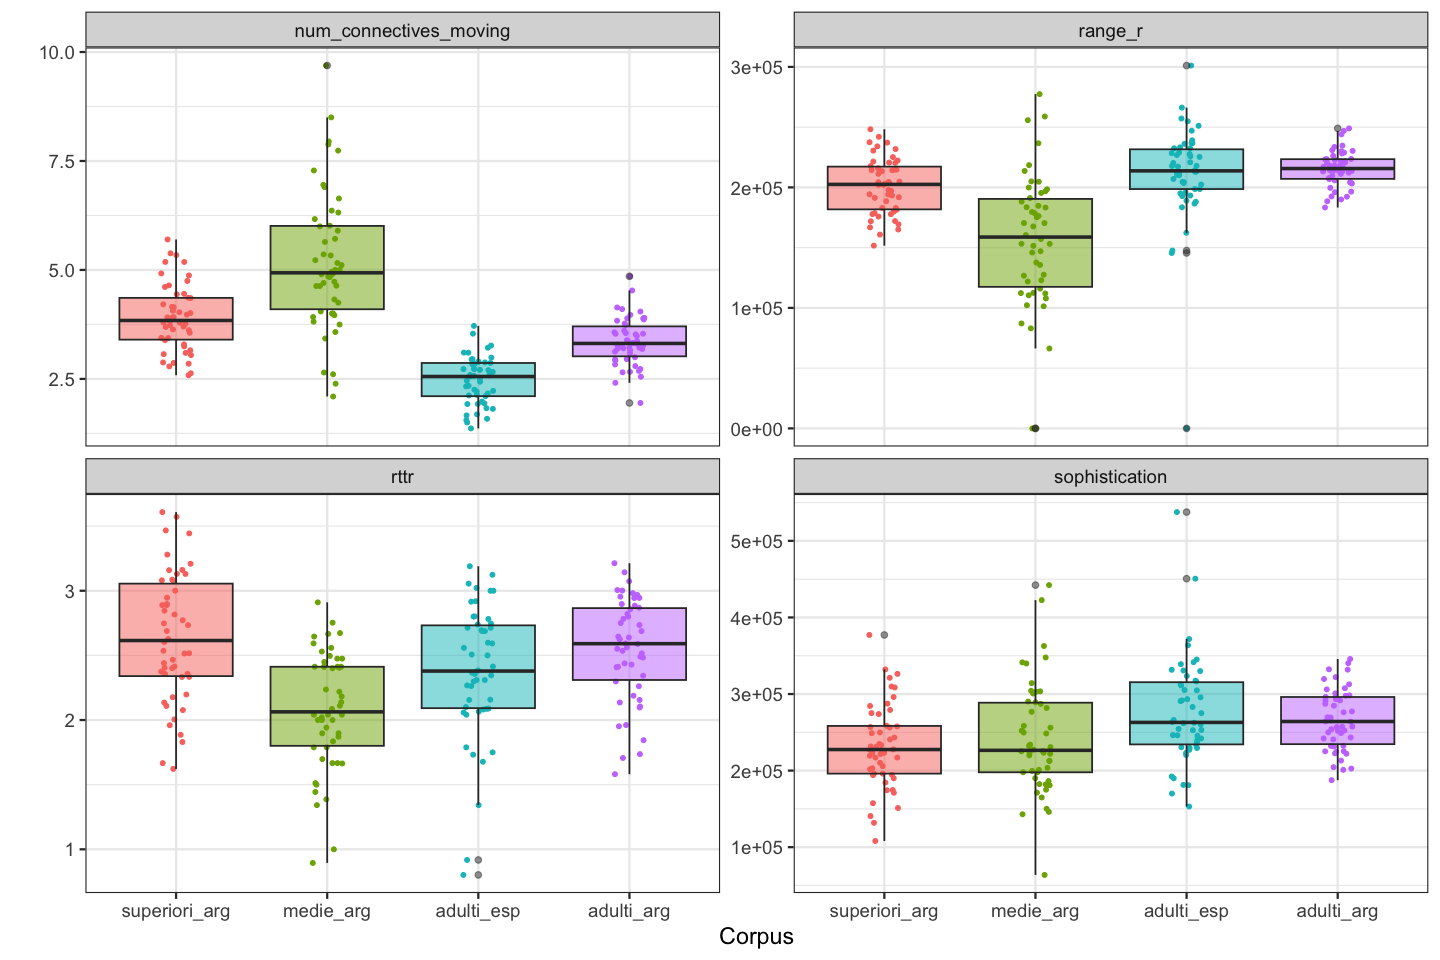

In [83]:
options(repr.plot.width=12, repr.plot.height=8)

plt_measures <- long_data %>%
  ggplot(aes(x = group, y = value)) +
  geom_jitter(aes(col = group), width = 0.1, size = 1) +
  geom_boxplot(aes(fill = group), alpha = 0.5) +
  xlab("Corpus") +
  ylab("") +
  theme_bw(base_size = 14) +
  theme(legend.position = "none") +
  facet_wrap(~measure, scales = "free_y")

plt_measures
ggsave("figures/boxplot_measures.png", plt_measures,
       device = "png", create.dir = TRUE,
       width = 12, height = 8, dpi = 600, bg = "transparent")

`summarise()` has grouped output by 'measure'. You can override using the
`.groups` argument.
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”


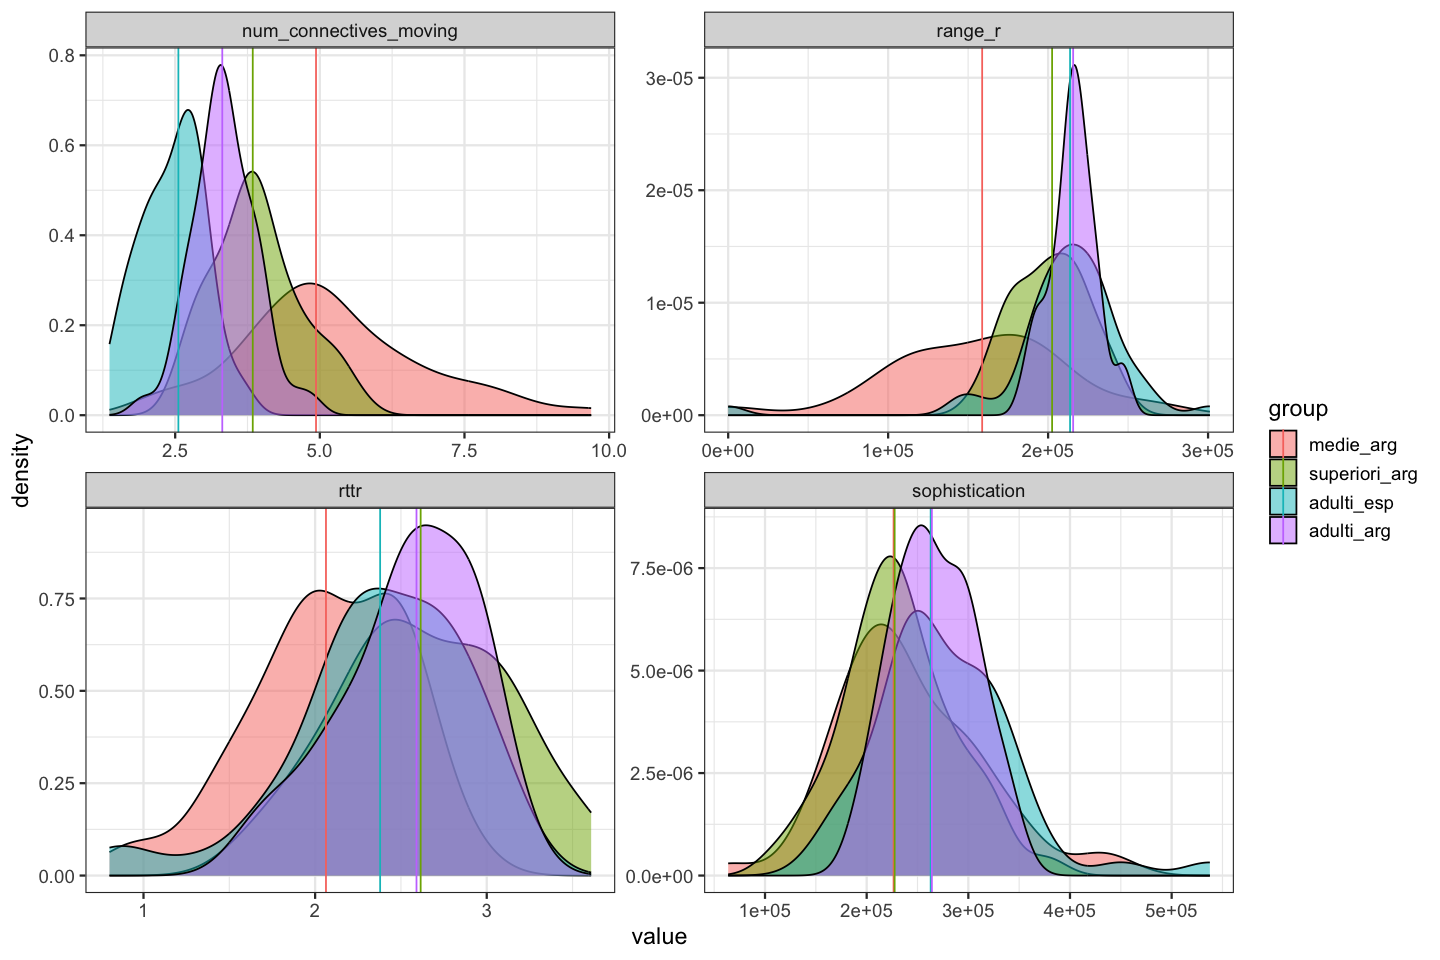

In [45]:
#check distributions
options(repr.plot.width=12, repr.plot.height=8)

medians <- long_data %>%
  group_by(measure, group) %>%
  summarise(median = median(value, na.rm = TRUE))

ggplot(long_data, aes(x = value, fill = group)) +
  geom_density(alpha = 0.5) +
  geom_vline(data = medians, aes(xintercept = median, color = group),
             linetype = "solid") +
  theme_bw(base_size = 14) +
  facet_wrap(~measure, scales = "free")

In [ ]:
get_box <- function(df, var, meas) {
  options(repr.plot.width=6, repr.plot.height=6)
  var = sym(var)
  (plt = df %>%
   ggplot(aes(x = group, y = !!var)) +
   geom_jitter(aes(col = group), width = 0.1, size = 1) +
   geom_boxplot(aes(fill = group), alpha = 0.5) +
   theme_bw(base_size = 14))
   plt = plt + theme(legend.position = "none")
   plt = plt + ylab("ciao jenny")
  print(plt)
  ggsave(paste("figures/boxplot_", var, ".png"), plt,
         dpi = 600, device = "png", width = 6, height = 6)
}

In [ ]:
get_box2 <- function(df, meas) {
  options(repr.plot.width=6, repr.plot.height=6)
  (plt = df %>%
   ggplot(aes(x = group, y = value)) +
   geom_jitter(aes(col = group), width = 0.1, size = 1) +
   geom_boxplot(aes(fill = group), alpha = 0.5) +
   ylab(glue({meas})) +
   theme_bw(base_size = 14))
   plt = plt + theme(legend.position = "none")
  print(plt)
  ggsave(paste("figures/boxplot_", var, ".png"), plt,
         dpi = 600, device = "png", width = 6, height = 6)
}

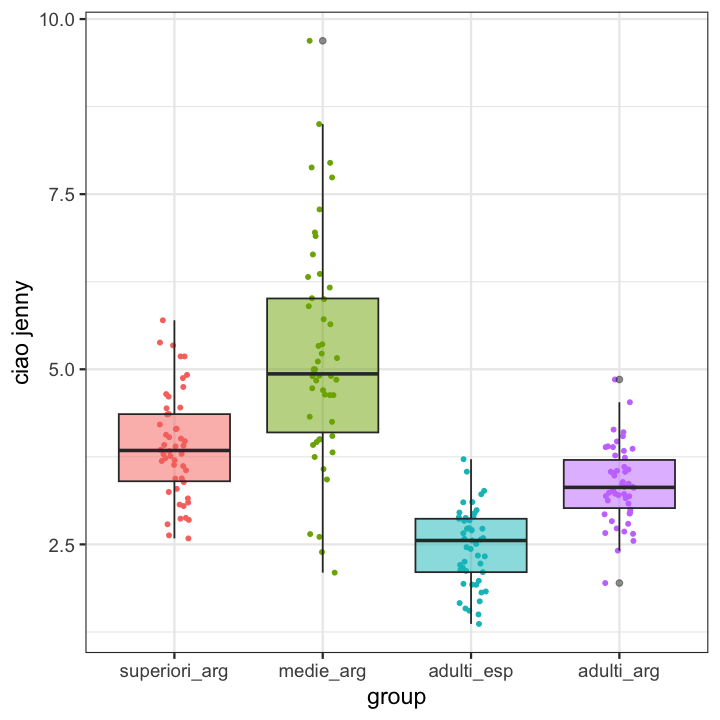

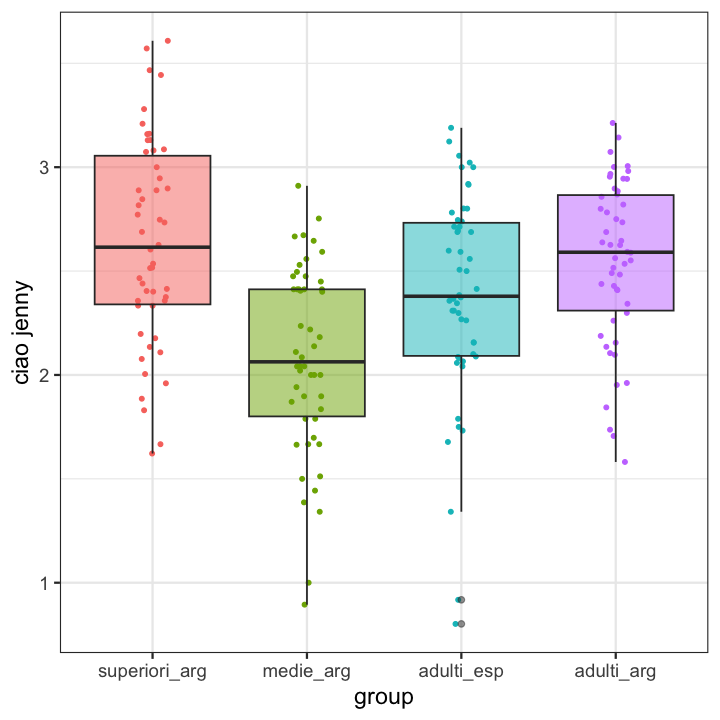

Warning message:
“There were 4 warnings in `mutate()`.
The first warning was:
ℹ In argument: `plots = map(data, function(t) get_box(t, "value"))`.
Caused by warning:
! Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings.”


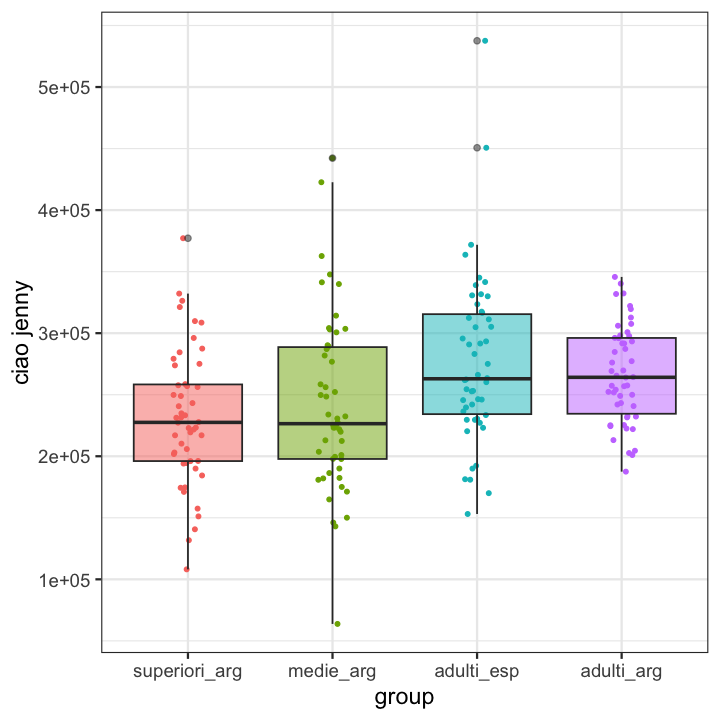

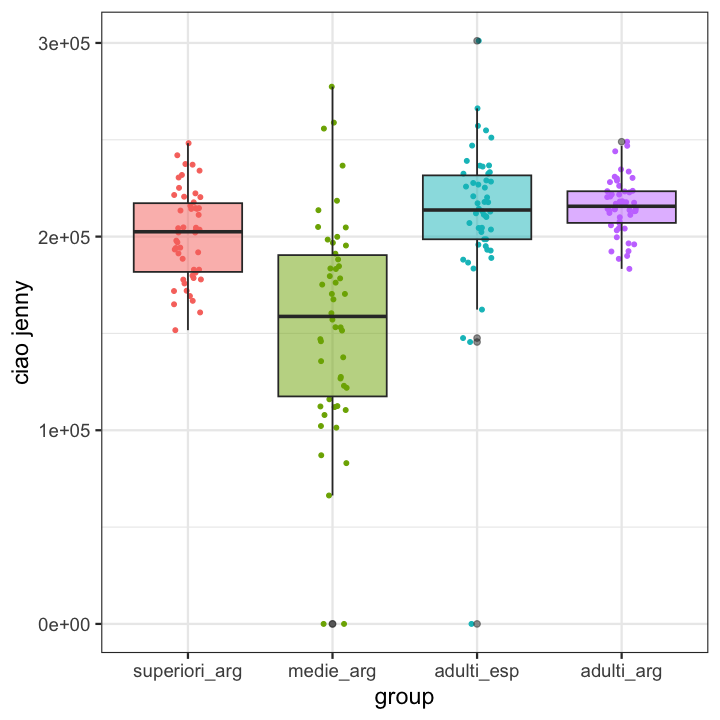

In [85]:
nested_data <- long_data %>%
  nest(data = !c(measure)) %>%
  mutate(plots = map(data, function(t) get_box(t, "value")))

In [ ]:
library(broom)

long_data$group <- relevel(long_data$group,
                           ref = "superiori_arg")

models <- long_data %>%
  nest(data = -measure) %>%
  mutate(
    fit = map(data, ~ lm(value ~ group, data = .x)),
    tidied = map(fit, tidy),
    glanced = map(fit, glance)
  ) %>%
  unnest(glanced)

### Correspondence analysis

In [ ]:
# load libraries for correspondence analysis

library("FactoMineR")
library("factoextra")

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [ ]:
ca_data <- data %>%
  filter(group %in% c("L1_lower", "L1_upper", "coris", "blogs")) %>%
  mutate(group = factor(group,
                        levels = c("L1_lower", "L1_upper", "coris", "blogs"),
                        labels = c("medie_arg",
                                   "superiori_arg",
                                   "adulti_esp",
                                   "adulti_arg"))) %>%
  select(c(group, all_of(conn_cols))) %>%
  pivot_longer(- group, names_to = "connectives", values_to = "counts") %>%
  group_by(group, connectives) %>%
  summarise(total_connectives = sum(counts)) %>%
  pivot_wider(names_from = group, values_from = total_connectives) %>%
  filter(rowSums(select(., -connectives)) > 0)

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


In [ ]:
ca_matrix <- as.matrix(ca_data %>% select(-connectives))
rownames(ca_matrix) <- ca_data$connectives

In [ ]:
ca_results <- CA(ca_matrix, graph = FALSE)

In [ ]:
head(dict)

lemma,coris_freq,demauro_use
<chr>,<dbl>,<chr>
a.causa.d,10880,CO
a.condizione.che,1284,CO
a.dire.il.vero,1237,NA
a.dire.la.verità,3453,CO
a.dispetto.d,1326,CO
a.meno.che,6528,CO


In [ ]:
soph <- dict %>%
  filter(lemma %in% rownames(ca_matrix)) %>%
  mutate(coris_freq = log10(coris_freq)) %>%
  pull(coris_freq)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


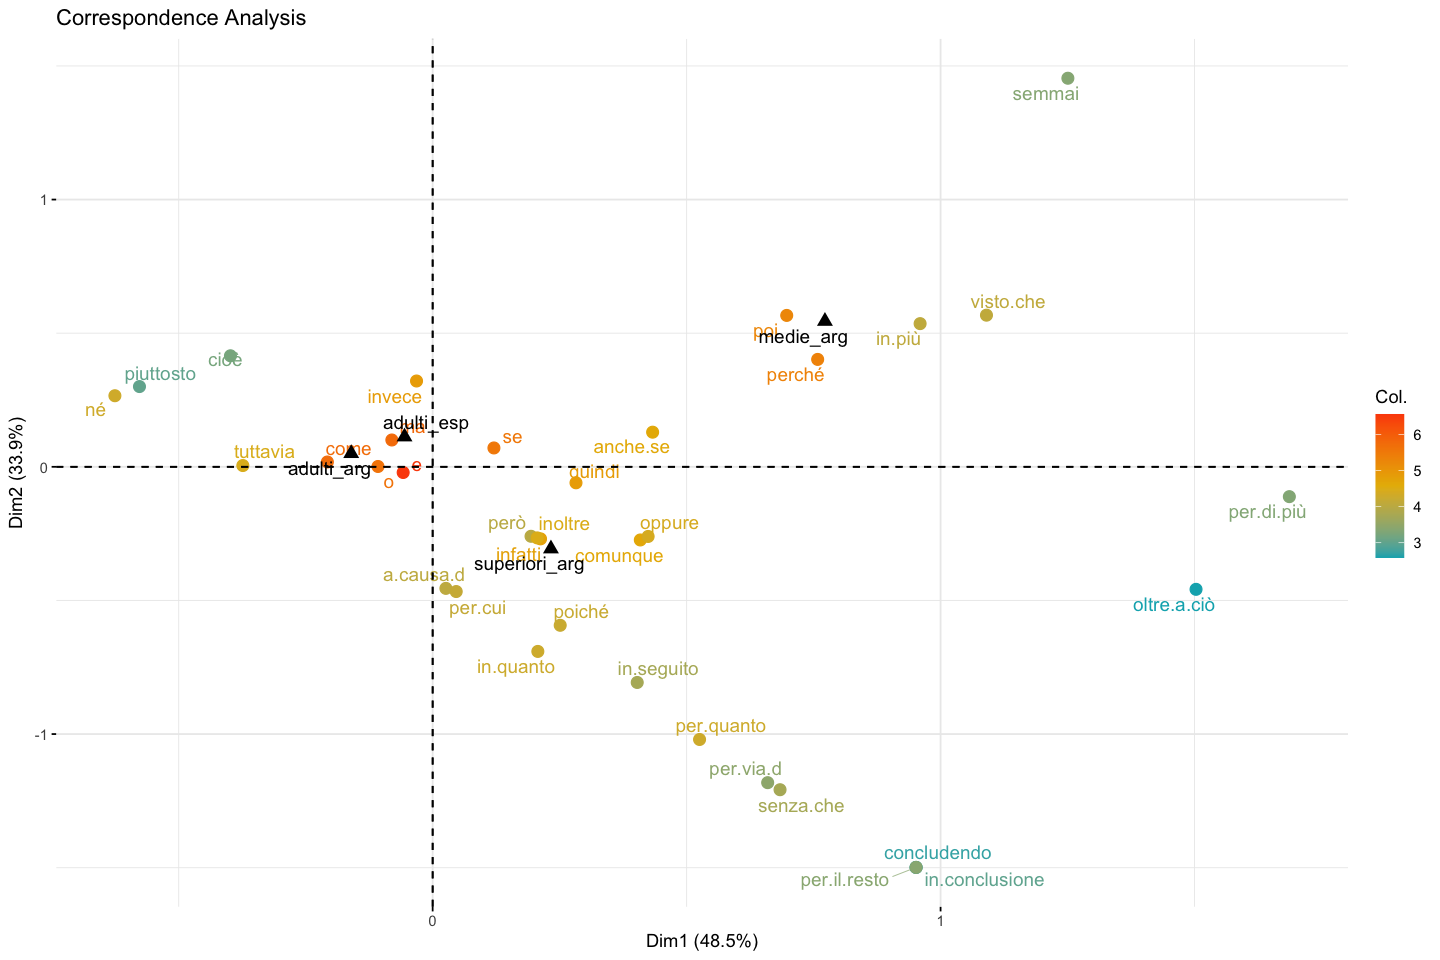

In [ ]:
options(ggrepel.max.overlaps = 20, 
repr.plot.width=12, repr.plot.height=8)

#plot that shows only the 20 most contributing connectives, color according to frequency values 



ca_biplot <- fviz_ca_biplot(ca_results,
                            map = "symmetric",
                            #arrow = c(FALSE, FALSE),
                            select.row = list(contrib = 35),
                            col.row = soph,
                            gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
                            col.col = "black",
                            pointsize = 3,
                            repel = TRUE,
                            title = "Correspondence Analysis")
ca_biplot

#ggsave("CA_plot.png", CA_plot, units = "cm", dpi = 300, width = 25, height = 20, bg = "transparent")